In [2]:
import time
from pathlib import Path
from urllib.parse import quote

from IPython.display import Markdown, Image
import requests
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import MolsToGridImage

/opt/conda/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [3]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [ ]:
### Determine a query compound

The structure of AZD5991:


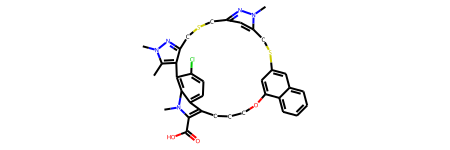

In [4]:
query = "Cc1c2c(nn1C)CSCc1cc(n(C)n1)CSc1cc(c3ccccc3c1)OCCCc1c(C(=O)O)n(C)c3c-2c(Cl)ccc13"  # AZD5991
print("The structure of AZD5991:")
Chem.MolFromSmiles(query)

In [ ]:
### Create task and get the job key

In [5]:
def query_pubchem_for_similar_compounds(smiles, threshold=75, n_records=10):
    """
    Query PubChem for similar compounds and return the job key.

    Parameters
    ----------
    smiles : str
        The canonical SMILES string for the given compound.
    threshold : int
        The threshold of similarity, default 75%. In PubChem, the default threshold is 90%.
    n_records : int
        The maximum number of feedback records.

    Returns
    -------
    str
        The job key from the PubChem web service.
    """
    escaped_smiles = quote(smiles).replace("/", ".")
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/similarity/smiles/{escaped_smiles}/JSON?Threshold={threshold}&MaxRecords={n_records}"
    r = requests.get(url)
    r.raise_for_status()
    key = r.json()["Waiting"]["ListKey"]
    return key


In [6]:
job_key = query_pubchem_for_similar_compounds(query)

In [ ]:
### Download results when job finished

In [7]:
def check_and_download(key, attempts=30):
    """
    Check job status and download PubChem CIDs when the job finished

    Parameters
    ----------
    key : str
        The job key of the PubChem service.
    attempts : int
        The time waiting for the feedback from the PubChem service.

    Returns
    -------
    list
        The PubChem CIDs of similar compounds.
    """
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/listkey/{key}/cids/JSON"
    print(f"Querying for job {key} at URL {url}...", end="")
    while attempts:
        r = requests.get(url)
        r.raise_for_status()
        response = r.json()
        if "IdentifierList" in response:
            cids = response["IdentifierList"]["CID"]
            break
        attempts -= 1
        print(".", end="")
        time.sleep(10)
    else:
        raise ValueError(f"Could not find matches for job key: {key}")
    return cids

In [8]:
similar_cids = check_and_download(job_key)

Querying for job 1384961596748200574 at URL https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/listkey/1384961596748200574/cids/JSON...

In [ ]:
### Get canonical SMILES for resulting molecules

In [9]:
def smiles_from_pubchem_cids(cids):
    """
    Get the canonical SMILES string from the PubChem CIDs.

    Parameters
    ----------
    cids : list
        A list of PubChem CIDs.

    Returns
    -------
    list
        The canonical SMILES strings of the PubChem CIDs.
    """
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{','.join(map(str, cids))}/property/CanonicalSMILES/JSON"
    r = requests.get(url)
    r.raise_for_status()
    return [item["CanonicalSMILES"] for item in r.json()["PropertyTable"]["Properties"]]

In [10]:
similar_smiles = smiles_from_pubchem_cids(similar_cids)

In [ ]:
### Create the RDKit molecules and depict them

,smiles,CIDs,ROMol
0,CC1=C2C(=NN1C)CSCC3=NN(C(=C3)CSC4=CC5=CC=CC=C5...,131634760,
1,CC1CN(C(=O)C2=C(C3=C(N12)C(=C(C=C3)Cl)C4=C(N(N...,134828256,
2,CC1=NN(C(=C1C2=CC=CC3=C2N(C(=C3CCCOC4=CC=CC5=C...,66575373,
3,CC1CC2=C(C=CC3=C2C(=C(N3CC4=CC=C(C=C4)Cl)CC(C)...,9960281,
4,B(C1=C(C=C(C=C1)OCC2=NN(C(=C2C3=CC=CC4=C3N(C(=...,121487984,

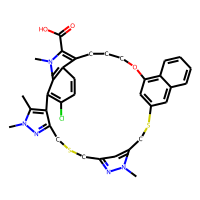
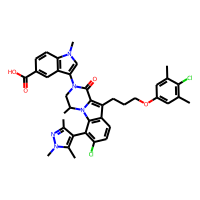
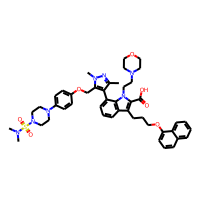
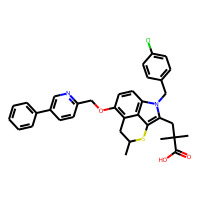
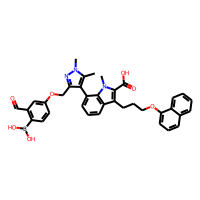

In [11]:
query_results_df = pd.DataFrame({"smiles": similar_smiles, "CIDs": similar_cids})
PandasTools.AddMoleculeColumnToFrame(query_results_df, smilesCol="smiles")
query_results_df.head(5)

In [ ]:
### Show the compounds with images using RDKit's drawing functions

In [12]:
def multi_preview_smiles(query_smiles, query_name, similar_molecules_pd):
    """
    Show query and similar compounds in 2D structure representation.

    Parameters
    ----------
    query_smiles : str
        The SMILES string of query compound.
    query_name : str
        The name of query compound.
    similar_molecules_pd : pandas
        The pandas DataFrame which contains the SMILES string and CIDs of similar molecules.

    Returns
    -------
    MolsToGridImage
    """

    legends = [f"PubChem CID: {str(s)}" for s in similar_molecules_pd["CIDs"].tolist()]
    molecules = [Chem.MolFromSmiles(s) for s in similar_molecules_pd["smiles"]]
    query_smiles = Chem.MolFromSmiles(query_smiles)
    return MolsToGridImage(
        [query_smiles] + molecules,
        molsPerRow=3,
        subImgSize=(300, 300),
        maxMols=len(molecules),
        legends=([query_name] + legends),
        useSVG=True,
    )

The results of querying similar compounds for AZD5991AZD5991:


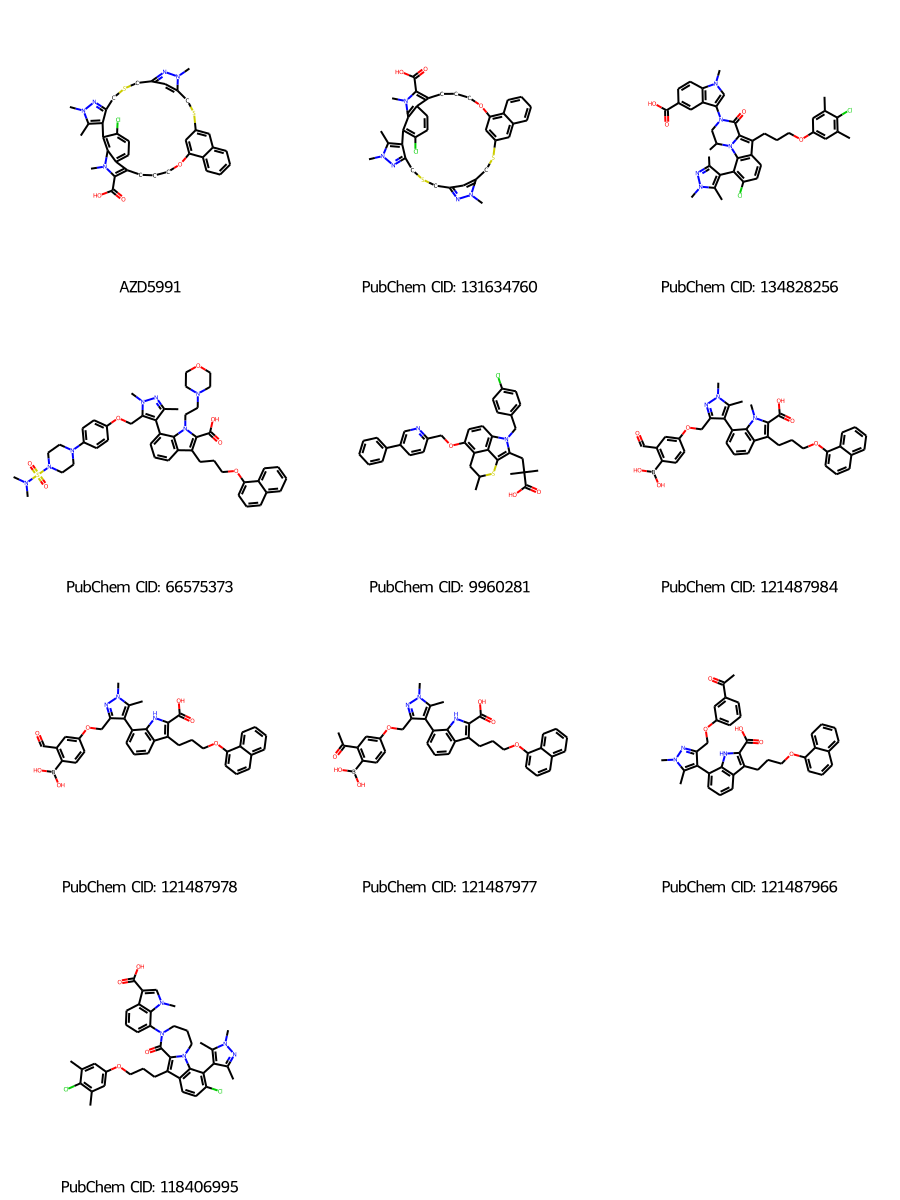

In [14]:
print("The results of querying similar compounds for AZD5991AZD5991:")
multi_preview_smiles(query, "AZD5991", query_results_df)